## Model Training

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("preprocessed_forecast_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Marketing_Spend   100000 non-null  float64
 1   Product_Price     100000 non-null  float64
 2   Competitor_Price  100000 non-null  float64
 3   Region            100000 non-null  object 
 4   Product_Category  100000 non-null  object 
 5   Channel_Type      100000 non-null  object 
 6   Festival_Week     100000 non-null  object 
 7   Store_Type        100000 non-null  object 
 8   Weekly_Sales      100000 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 6.9+ MB


### Let's pull up Top 5 rows

In [48]:
df.head()

,Marketing_Spend,Product_Price,Competitor_Price,Region,Product_Category,Channel_Type,Festival_Week,Store_Type,Weekly_Sales
0,4370.86,35.43,33.77,North,Electronics,Online,No,Flagship,682
1,9556.43,51.28,54.78,South,Furniture,In-store,No,Flagship,864
2,7587.95,18.93,13.97,East,Grocery,In-store,No,Flagship,1005
3,6387.93,50.22,49.40,North,Grocery,Online,No,Online-only,770
4,2404.17,28.28,34.36,North,Electronics,In-store,No,Franchise,596


Let us prepare the data for model training

### Preprocessing Pipeline

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.pipeline import Pipeline
import pandas as pd

# Separate features and target
X = df.drop(columns=['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

# Identify feature types
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, dtype=int), cat_features)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit-transform on training data, transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Numerical features: ['Marketing_Spend', 'Product_Price', 'Competitor_Price']
Categorical features: ['Region', 'Product_Category', 'Channel_Type', 'Festival_Week', 'Store_Type']


### Creating a function to evaluate the models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_regression_model(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    return mse, rmse, mae, r2

### Model Building

#### Training Baseline Models

#### Evaliation Metrics

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

# Define regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(tree_method='gpu_hist', gpu_id=0, single_precision_histogram=True)
}

# Create DataFrames to store the results
train_results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2 Score'])
test_results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2 Score'])

# Train and evaluate models
for model_name, model in regression_models.items():
    print(f"Training {model_name}...")

    model.fit(X_train_preprocessed, y_train)

    train_pred = model.predict(X_train_preprocessed)
    test_pred = model.predict(X_test_preprocessed)

    # Evaluate on train and test data
    train_mse, train_rmse, train_mae, train_r2 = evaluate_regression_model(y_train, train_pred)
    test_mse, test_rmse, test_mae, test_r2 = evaluate_regression_model(y_test, test_pred)

    # Store results
    train_results.loc[len(train_results)] = [model_name, train_mse, train_rmse, train_mae, train_r2]
    test_results.loc[len(test_results)] = [model_name, test_mse, test_rmse, test_mae, test_r2]

# View the results
print("\nTrain Results:\n", train_results)
print("\nTest Results:\n", test_results)


Training Linear Regression...
Training Decision Tree...


Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training XGBoost...

Train Results:
                Model          MSE       RMSE        MAE  R2 Score
0  Linear Regression  2552.063725  50.517954  40.284350  0.886062
1      Decision Tree     0.000000   0.000000   0.000000  1.000000
2      Random Forest   387.368785  19.681687  15.562351  0.982706
3  Gradient Boosting  2536.284954  50.361542  40.155219  0.886766
4           AdaBoost  2783.028435  52.754416  42.103234  0.875750
5            XGBoost  2270.899902  47.653960  37.874161  0.898614

Test Results:
                Model          MSE       RMSE        MAE  R2 Score
0  Linear Regression  2534.713982  50.345943  40.347559  0.885951
1      Decision Tree  5357.990700  73.198297  58.522300  0.758918
2      Random Forest  2742.522843  52.369102  41.949320  0.876600
3  Gradient Boosting  2563.858827  50.634562  40.623484  0.884639
4           AdaBoost  2783.689904  52.760685  42.207229  0.874748
5           

#### These are the training results

In [10]:
train_results = train_results.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
train_results

,Model,MSE,RMSE,MAE,R2 Score
0,Decision Tree,0.000000,0.000000,0.000000,1.000000
1,Random Forest,387.368785,19.681687,15.562351,0.982706
2,XGBoost,2270.899902,47.653960,37.874161,0.898614
3,Gradient Boosting,2536.284954,50.361542,40.155219,0.886766
4,Linear Regression,2552.063725,50.517954,40.284350,0.886062
5,AdaBoost,2783.028435,52.754416,42.103234,0.875750


#### These are the test results

In [11]:
test_results = test_results.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
test_results

,Model,MSE,RMSE,MAE,R2 Score
0,Linear Regression,2534.713982,50.345943,40.347559,0.885951
1,Gradient Boosting,2563.858827,50.634562,40.623484,0.884639
2,XGBoost,2619.321289,51.179305,41.069168,0.882144
3,Random Forest,2742.522843,52.369102,41.949320,0.876600
4,AdaBoost,2783.689904,52.760685,42.207229,0.874748
5,Decision Tree,5357.990700,73.198297,58.522300,0.758918


### 🔧 Let Us Perform Hyperparameter Tuning on select models

✅ **1. Gradient Boosting Regressor**  
- **Why:** Reduces bias through iterative improvements, making it highly effective.  
- **Use Case:** Great for modeling complex, non-linear patterns.  
- **Tuning Needed:** Several key parameters (`n_estimators`, `learning_rate`, `max_depth`, `subsample`) affect accuracy and training time.

✅ **2. XGBoost Regressor**  
- **Why:** Combines gradient boosting with built-in regularization for better control over overfitting.  
- **Use Case:** Frequently tops the leaderboard in regression tasks due to its scalability and robustness.  
- **Tuning Needed:** Parameters like `max_depth`, `learning_rate`, `subsample`, and `colsample_bytree` require careful tuning for optimal performance.

✅ **3. AdaBoost Regressor**  
- **Why:** Boosts weak learners sequentially, improving overall performance with emphasis on hard-to-fit examples.  
- **Use Case:** Works well with simpler base models when data noise is minimal.  
- **Tuning Needed:** Key hyperparameters (`n_estimators`, `learning_rate`, `loss`) shape its learning behavior and resilience to outliers.

✅ **4. Decision Tree Regressor**  
- **Why:** Simple yet interpretable, with a branching logic that handles both linear and non-linear relationships.  
- **Use Case:** Ideal for understanding variable splits and model behavior. Often used as a base learner in ensembles.  
- **Tuning Needed:** Parameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` are crucial for balancing bias and variance.

✅ **5. Random Forest Regressor**  
- **Why:** An ensemble of trees that reduces overfitting and handles noisy data effectively.  
- **Use Case:** Solid default choice for most regression tasks with medium-to-large datasets.  
- **Tuning Needed:** Hyperparameters (`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`) influence both training speed and generalization.




In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import numpy as np
import pandas as pd

# Define param_dict with actual model instances
param_dict = {
    "GradientBoostingRegressor": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0]
        }
    },
    "XGBRegressor": {
        "model": XGBRegressor(tree_method="hist",device="cuda"),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    },
    "AdaBoostRegressor": {
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "loss": ['linear', 'square', 'exponential']
        }
    },
    "DecisionTreeRegressor": {
        "model": DecisionTreeRegressor(),
        "params": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    }
}


# Create results DataFrames
train_results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2 Score'])
test_results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2 Score'])
best_params_df = pd.DataFrame(columns=['Model', 'Best Parameters'])

# Loop through each model and run GridSearchCV
for model_name, config in param_dict.items():
    print(f"\n🔍 Tuning and training {model_name}...")

    model = config['model']
    param_grid = {f"{model_name.lower()}__{k}": v for k, v in config['params'].items()}

    # Create pipeline
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([(model_name.lower(), model)])

    grid = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=2, verbose=0)
    grid.fit(X_train_preprocessed, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    # Predictions
    train_pred = best_model.predict(X_train_preprocessed)
    test_pred = best_model.predict(X_test_preprocessed)

    # Evaluation metrics
    train_mse, train_rmse, train_mae, train_r2 = evaluate_regression_model(y_train, train_pred)
    test_mse, test_rmse, test_mae, test_r2 = evaluate_regression_model(y_test, test_pred)

    # Store results
    train_results.loc[len(train_results)] = [model_name, train_mse, train_rmse, train_mae, train_r2]
    test_results.loc[len(test_results)] = [model_name, test_mse, test_rmse, test_mae, test_r2]
    best_params_df.loc[len(best_params_df)] = [model_name, best_params]



🔍 Tuning and training GradientBoostingRegressor...
✅ Best Parameters for GradientBoostingRegressor: {'gradientboostingregressor__subsample': 1.0, 'gradientboostingregressor__n_estimators': 300, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__learning_rate': 0.05}

🔍 Tuning and training XGBRegressor...


/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:07] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/anupam9k/AI_Resume_Projects/02. Smart_Forecasting_&_Churn_AI/sfenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:50:07] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. 

✅ Best Parameters for XGBRegressor: {'xgbregressor__subsample': 1.0, 'xgbregressor__n_estimators': 200, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 1.0}

🔍 Tuning and training AdaBoostRegressor...
✅ Best Parameters for AdaBoostRegressor: {'adaboostregressor__n_estimators': 50, 'adaboostregressor__loss': 'linear', 'adaboostregressor__learning_rate': 1.0}

🔍 Tuning and training DecisionTreeRegressor...
✅ Best Parameters for DecisionTreeRegressor: {'decisiontreeregressor__min_samples_split': 10, 'decisiontreeregressor__min_samples_leaf': 1, 'decisiontreeregressor__max_depth': 10}

🔍 Tuning and training RandomForestRegressor...
✅ Best Parameters for RandomForestRegressor: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 10}


#### These are the training results after hyperparameter tuning

In [13]:
train_results = train_results.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
train_results

,Model,MSE,RMSE,MAE,R2 Score
0,RandomForestRegressor,2273.866192,47.685073,38.088574,0.898482
1,DecisionTreeRegressor,2389.528147,48.882800,38.865865,0.893318
2,GradientBoostingRegressor,2515.963573,50.159382,39.999189,0.887673
3,XGBRegressor,2525.425049,50.253607,40.071365,0.887251
4,AdaBoostRegressor,2818.720833,53.091627,42.376287,0.874156


#### These are the test results after hyperparameter tuning

In [14]:
test_results = test_results.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
test_results

,Model,MSE,RMSE,MAE,R2 Score
0,XGBRegressor,2554.254395,50.539632,40.542702,0.885072
1,GradientBoostingRegressor,2554.969313,50.546704,40.558333,0.885039
2,RandomForestRegressor,2579.033830,50.784189,40.726455,0.883957
3,DecisionTreeRegressor,2759.325386,52.529281,42.066939,0.875844
4,AdaBoostRegressor,2823.652939,53.138055,42.512226,0.872950


As per the above results, we can see that **XGBRegressor** is the best models with r2_sscore of **88.5072%** and RMSE of **50.539632** . So, let us choose **XGBRegressor** as our final model.

In [29]:
best_model_params = best_params_df[best_params_df['Model'] == 'XGBRegressor'].iloc[0]['Best Parameters']

In [30]:
best_model_params

{'xgbregressor__subsample': 1.0,
 'xgbregressor__n_estimators': 200,
 'xgbregressor__max_depth': 3,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__colsample_bytree': 1.0}

## Model Validation & Evaluation

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from xgboost import XGBRegressor

# Final model pipeline
best_model = Pipeline(steps=[
    ('model',XGBRegressor(tree_method="hist",device="cuda", n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42,
    subsample= 1.0, colsample_bytree= 0.8))
])

# Cross-validation with scoring
cv_results = cross_validate(
    best_model,
    X_train_preprocessed,  # Ensure this is the preprocessed feature matrix
    y_train,
    scoring={'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
    cv=10,
    return_train_score=True,
    n_jobs=2
)

# Display results
print("CV Mean MSE:", -np.mean(cv_results['test_neg_mse']))
print("CV Mean R²:", np.mean(cv_results['test_r2']))

CV Mean MSE: 2579.4097412109377
CV Mean R²: 0.8848243713378906


### Residual Plot (Train vs Test)

#### Fit the best model on training data

In [35]:
# Fit best model on entire training data
best_model.fit(X_train_preprocessed, y_train)

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device='cuda',
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_train_pred = best_model.predict(X_train_preprocessed)
y_test_pred = best_model.predict(X_test_preprocessed)

# Residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred


#### Plot Residuals

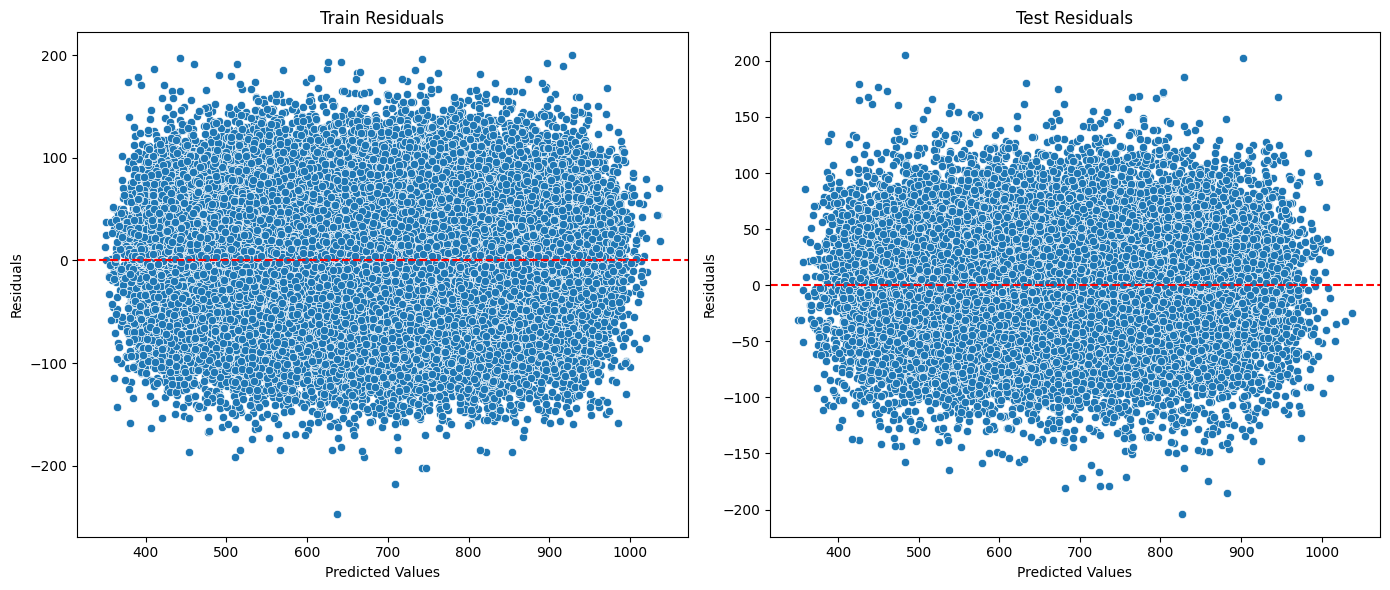

In [38]:
plt.figure(figsize=(14, 6))

# Train residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_pred, y=residuals_train)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Test residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_pred, y=residuals_test)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


### Interpretation of Residual Plots:

1. Symmetry around 0:

- Both train and test residuals are fairly evenly distributed around the red zero line, indicating:

- No obvious systematic bias.

- The model is not consistently over- or under-predicting.

2. No funnel shape or curvature:

- There's no clear pattern or cone shape, which suggests:

- Homoscedasticity (constant variance of errors) is satisfied.

- Model assumptions for regression hold well.

3. Random scatter:

- The residuals appear randomly spread → a good sign.

- No clustering or obvious structure → means the model is likely capturing the patterns in the data well.

✅ Final Verdict:
The residuals indicate that the XGBRegressor model is well-fitted. There are no major red flags such as:

    - Heteroscedasticity

    - Non-linear patterns in residuals

    - Systematic bias in predictions

##### Residual Distribution Plot

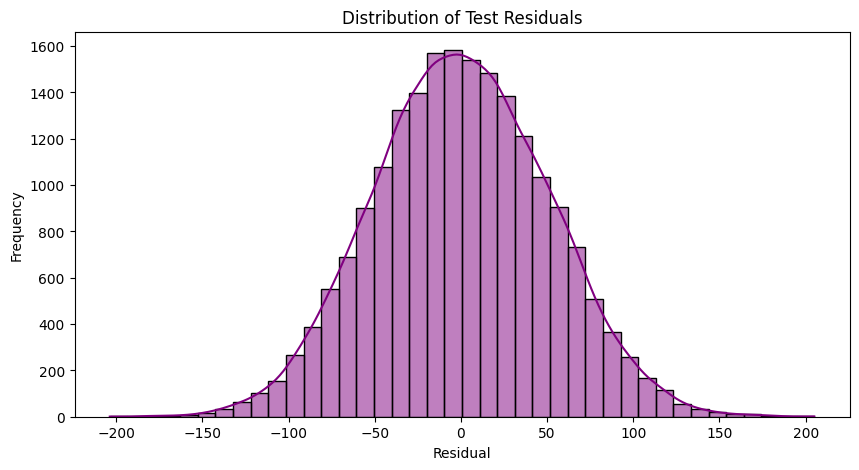

In [39]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals_test, kde=True, bins=40, color='purple')
plt.title("Distribution of Test Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

This plot shows the **distribution of test residuals** (i.e., the difference between actual and predicted values) for your **XGBoost Regressor** model, and it's an excellent diagnostic plot for assessing model performance.

### ✅ Observations

1. **Near-Normal Distribution**:

   * The residuals are **bell-shaped and symmetric**, centered around **0**, which is a very good sign.
   * This implies that your model is **unbiased** — it doesn’t consistently underpredict or overpredict.

2. **No Heavy Skewness**:

   * The distribution doesn’t show any significant **skewness** to the left or right, indicating your model performs similarly across the entire range of predictions.

3. **Reasonable Spread**:

   * Most residuals fall between **-100 and +100**, suggesting that the error margin is relatively tight and consistent.
   * The long but thin tails (outliers) are acceptable and expected in real-world data.

4. **Smooth KDE Line**:

   * The purple KDE line closely follows the histogram, indicating a good fit for the residual distribution.

---

### 📉 What This Means for the Model

* ✅ **Model generalizes well** on unseen data.
* ✅ **Errors are random**, not systematic.
* ✅ **No heteroscedasticity** (i.e., variance of errors appears constant across predictions).
* ✅ Supports the **high CV R² of 0.88**.


### Let us save the model using pickle

In [41]:
import os
import pickle

# Ensure the directory exists
os.makedirs('models', exist_ok=True)

# Save the preprocessor
with open('models/forecast_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the trained model
with open('models/forecast_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Preprocessor and model saved successfully!")

Preprocessor and model saved successfully!
